## Setup


In [1]:
import json
import wandb
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

import torch
import transformers
from huggingface_hub import login
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import DataCollatorWithPadding
from transformers import Trainer, TrainingArguments
from arabert.preprocess import ArabertPreprocessor

sns.set()
%matplotlib inline

In [2]:
sns.set_style("whitegrid", {"axes.grid": False})

In [3]:
# project name for wandb.ai
project_name = "Arabic-Fully-Supervised-Propaganda-Detection"
run_name = "weighted-cross-entropy"

# defining data paths
labeled_data_path = "../data/processed/to_label.json"
lf_dev_data_path = "../data/processed/lf_dev.json"
test_data_path = "../data/processed/test_data.json"
access_tokens_path = "../data/access_tokens.json"

# defining model names
seed = 42
model_ckpt = "aubmindlab/bert-base-arabertv2"
model_name = "arabertv2-fully-supervised-arabic-propaganda"
model_path = f"../models/{model_name}"

In [4]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
transformers.set_seed(seed)

In [5]:
with open(access_tokens_path) as f:
    access_tokens = json.load(f)

In [6]:
login(access_tokens["huggingface"]["write_token"])

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


## Data Preprocessing


In [7]:
data = pd.read_json(labeled_data_path)
data.head(2)

,tweetid,tweet_text,text,tech,label
0,295735762505322497,النعيم أمي، وعين أمي، وقبلة أمي، فأكرمها يالله...,النعيم أمي، وعين أمي، وقبلة أمي، فأكرمها يالله...,None,0
1,1080873494227886086,RT @rood516: عرض الاجازه😍👌🏻1\nســــاعه\nقـــلم...,RT : عرض الاجازه1 ســــاعه قـــلم كــبك نظـــا...,None,0


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2100 entries, 0 to 2099
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tweetid     2100 non-null   int64 
 1   tweet_text  2100 non-null   object
 2   text        2100 non-null   object
 3   tech        202 non-null    object
 4   label       2100 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 98.4+ KB


In [9]:
# getting class weights
w = data.label.value_counts(normalize=True).to_numpy()
w

array([0.90380952, 0.09619048])

In [10]:
# splitting the data to 60-20-20 % portions
train, valid = train_test_split(
    data, train_size=0.6, stratify=data.label, random_state=seed
)
valid, test = train_test_split(
    valid, train_size=0.5, stratify=valid.label, random_state=seed
)

In [11]:
# generating the labeling functions development dataset
lf_dev, _ = train_test_split(
    train, train_size=500, stratify=train.label, random_state=seed
)

In [12]:
len(train), len(valid), len(test), len(lf_dev)

(1260, 420, 420, 500)

In [13]:
train = train.reset_index(drop=True)
valid = valid.reset_index(drop=True)
test = test.reset_index(drop=True)


lf_dev = lf_dev.reset_index(drop=True)
lf_dev.to_json(lf_dev_data_path)
test.to_json(test_data_path)

## Tokenization


In [14]:
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [15]:
# transformimg from pandas to hugging face datasets

train = Dataset.from_pandas(train, split="train")
valid = Dataset.from_pandas(valid, split="valid")
test = Dataset.from_pandas(test, split="test")

ds = DatasetDict({"train": train, "validation": valid, "test": test})
ds

DatasetDict({
    train: Dataset({
        features: ['tweetid', 'tweet_text', 'text', 'tech', 'label'],
        num_rows: 1260
    })
    validation: Dataset({
        features: ['tweetid', 'tweet_text', 'text', 'tech', 'label'],
        num_rows: 420
    })
    test: Dataset({
        features: ['tweetid', 'tweet_text', 'text', 'tech', 'label'],
        num_rows: 420
    })
})

In [16]:
# process tweet text

arabert_prep = ArabertPreprocessor(model_name=model_ckpt)


def process_text(text):
    """Process tweet text by removing links, mentions, and hashtags symbol."""
    clean_text = arabert_prep.preprocess(text)
    clean_text = arabert_prep.unpreprocess(clean_text)
    clean_text = clean_text.replace("[رابط]", "")
    clean_text = clean_text.replace("[مستخدم]", "")
    clean_text = clean_text.replace("RT", "")
    clean_text = clean_text.replace(":", "")
    return arabert_prep.preprocess(clean_text.strip())


ds = ds.map(
    lambda x: {"text": [process_text(t) for t in x["text"]]},
    batched=True,
    remove_columns=["text"],
)

[2023-11-14 11:31:47,805 - farasapy_logger - WARNING]: Be careful with large lines as they may break on interactive mode. You may switch to Standalone mode for such cases.
Parameter 'function'=<function <lambda> at 0x7fd0bb460310> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Map:   0%|          | 0/1260 [00:00<?, ? examples/s]

Map:   0%|          | 0/420 [00:00<?, ? examples/s]

Map:   0%|          | 0/420 [00:00<?, ? examples/s]

In [17]:
def tokenize_ds(field):
    return tokenizer(field["text"], truncation=True)

In [18]:
cols = ds["train"].column_names.copy()
cols.remove("label")
cols

['tweetid', 'tweet_text', 'text', 'tech']

In [19]:
ds_encoded = ds.map(tokenize_ds, batched=True, remove_columns=cols)
ds_encoded

Map:   0%|          | 0/1260 [00:00<?, ? examples/s]

Map:   0%|          | 0/420 [00:00<?, ? examples/s]

Map:   0%|          | 0/420 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1260
    })
    validation: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 420
    })
    test: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 420
    })
})

## Modeling


### Setup


In [20]:
def compute_scores(preds):
    logits, labels = preds
    pred = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, pred)
    f1 = f1_score(labels, pred)
    prec = precision_score(labels, pred)
    rec = recall_score(labels, pred)
    return {"Accuracy": acc, "Precision": prec, "Recall": rec, "F1": f1}

In [21]:
label_names = ["Transparent", "Propaganda"]
id2label = {i: l for i, l in enumerate(label_names)}
label2id = {l: i for i, l in enumerate(label_names)}

In [22]:
model = AutoModelForSequenceClassification.from_pretrained(
    model_ckpt,
    num_labels=len(label_names),
    id2label=id2label,
    label2id=label2id,
    token=access_tokens["huggingface"]["read_token"],
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at aubmindlab/bert-base-arabertv2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
training_args = TrainingArguments(
    output_dir=model_path,
    overwrite_output_dir=True,
    learning_rate=2e-5,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    num_train_epochs=5,
    weight_decay=1e-5,
    warmup_ratio=0.1,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    log_level="error",
    logging_steps=1,
    seed=seed,
    load_best_model_at_end=True,
)

### Training


In [24]:
if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True
    if torch.cuda.device_count() > 1:
        device = torch.device("cuda:0")
    else:
        device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [25]:
# inverting the weights for the weighted loss
w = 1 / w
w = w / w.sum()
w = torch.tensor(w, device=device, dtype=torch.float32)

In [26]:
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")  # [batch_size, num_labels]
        outputs = model(**inputs)
        logits = outputs.get("logits")  # [batch_size, num_labels]
        loss_fct = torch.nn.CrossEntropyLoss(weight=w)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

In [27]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [28]:
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=ds_encoded["train"],
    eval_dataset=ds_encoded["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_scores,
)

In [29]:
wandb.login(key=access_tokens["wandb"]["login"])

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [30]:
wandb.init(project=project_name, name=f"{model_name}-{run_name}")

wandb: Currently logged in as: bateekalmutairi. Use `wandb login --relogin` to force relogin
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [31]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.491900,0.508706,0.838095,0.351648,0.780488,0.484848
2,0.363300,0.401026,0.833333,0.347368,0.804878,0.485294
3,0.201700,0.363506,0.900000,0.491803,0.731707,0.588235
4,0.307100,0.398138,0.933333,0.644444,0.707317,0.674419
5,0.145000,0.389369,0.926190,0.604167,0.707317,0.651685


TrainOutput(global_step=100, training_loss=0.34716846883296965, metrics={'train_runtime': 77.541, 'train_samples_per_second': 81.247, 'train_steps_per_second': 1.29, 'total_flos': 199166846687040.0, 'train_loss': 0.34716846883296965, 'epoch': 5.0})

In [32]:
trainer.evaluate(ds_encoded["test"], metric_key_prefix="test")

{'test_loss': 0.32075390219688416,
 'test_Accuracy': 0.9047619047619048,
 'test_Precision': 0.5,
 'test_Recall': 0.8,
 'test_F1': 0.6153846153846154,
 'test_runtime': 1.4299,
 'test_samples_per_second': 293.736,
 'test_steps_per_second': 4.896,
 'epoch': 5.0}

In [33]:
test_outs = trainer.predict(ds_encoded["test"])
preds = np.argmax(test_outs[0], axis=-1)
labels = test_outs[1]

In [34]:
print(classification_report(labels, preds, target_names=label_names))

              precision    recall  f1-score   support

 Transparent       0.98      0.92      0.95       380
  Propaganda       0.50      0.80      0.62        40

    accuracy                           0.90       420
   macro avg       0.74      0.86      0.78       420
weighted avg       0.93      0.90      0.91       420



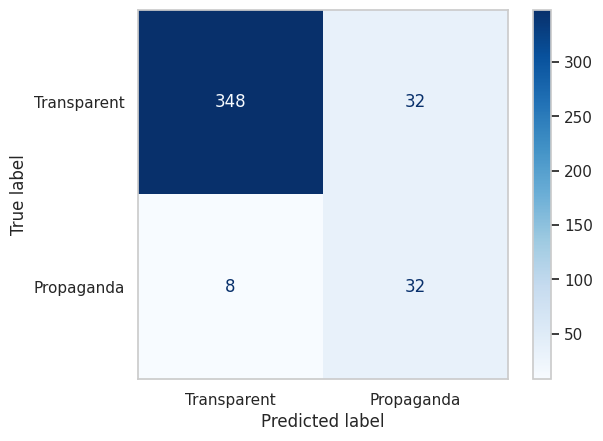

In [35]:
cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)


disp.plot(cmap="Blues")
plt.show()

In [36]:
trainer.save_model(model_path)

In [37]:
trainer.push_to_hub()

Upload 4 LFS files:   0%|          | 0/4 [00:00<?, ?it/s]

events.out.tfevents.1699961575.nl6hirvnmq.451.0:   0%|          | 0.00/22.4k [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/4.66k [00:00<?, ?B/s]

events.out.tfevents.1699961657.nl6hirvnmq.451.1:   0%|          | 0.00/503 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/541M [00:00<?, ?B/s]

'https://huggingface.co/Bmalmotairy/arabertv2-fully-supervised-arabic-propaganda/tree/main/'

In [38]:
wandb.finish()

eval/Accuracy,▁▁▆██
eval/F1,▁▁▅█▇
eval/Precision,▁▁▄█▇
eval/Recall,▆█▃▁▁
eval/loss,█▃▁▃▂
eval/runtime,▁▁▅▄█
eval/samples_per_second,██▄▅▁
eval/steps_per_second,██▄▅▁
test/Accuracy,▁
test/F1,▁
test/Precision,▁
